## Проект: Прогнозирование температуры звезды

**Dataset Description**

   В этом проекте нам нужно нам пришла задача от обсерватории «Небо на ладони»: придумать, как с помощью нейросети определять температуру на поверхности обнаруженных звёзд. 

**Данные**

 * База данных `6_class.csv` — обсерватории, с характеристиками 240 звезд.
 
**Описание полей данных:**
 * `L/Lo` — Относительная светимость, светимость звезды относительно Солнца.
 * `R/Ro` — Относительный радиус, радиус звезды относительно радиуса Солнца.
 * `Mv` — Абсолютная звёздная величина, физическая величина, характеризующая блеск звезды.
 * `Star color` — Звёздный цвет (white, red, blue, yellow, yellow-orange и др.), цвет звезды, который определяют на основе спектрального анализа.
 * `Star type` — Тип звезды:
 
     | id | Описание |
| ------------ | ----- |
| 0 | Коричневый карлик |
| 1 | Красный карлик |
| 2 | Белый карлик |
| 3 | Звёзды главной последовательности |
| 4 | Сверхгигант |
| 5 | Гипергигант |

**Цели**
 
 * Разработка модели нейронной сети для определения температуры на поверхности обнаруженных звезд.

 
**Структура проекта:**
 

 
**Предмет исследования:**

* База данных обсерватории, с характеристиками 240 звезд.
 

**Методы:** которые мы применим в данном исследовании включают в себя: 
* Загрузка и получение общей информации о данных.
* EDA
* Предобработка данных
* Пострение нейронных сетей
* Оптимизация параметров нейронной сети

**Используемые библитеки:** 
* Pandas
* Matplotlib
* Seaborn
* PyTorch
* Numpy

## Загрузка данных

Импортируем необходимые библиотеки:

In [1]:
! pip install torch
! pip install torchmetrics

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
import math
from sklearn.metrics import mean_squared_error
from torchmetrics import MeanSquaredError
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

RANDOM_SEED = 67
torch.manual_seed(67)
np.random.seed(67)

sns.set(rc={'figure.figsize':(20, 7)})

Присвоим переменной df данные обсерватории:

In [2]:
df = pd.read_csv('/datasets/6_class.csv')

Проверим корректность загрузки:

In [3]:
df.head()

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.002400,0.1700,16.12,0,Red
1,1,3042,0.000500,0.1542,16.60,0,Red
2,2,2600,0.000300,0.1020,18.70,0,Red
3,3,2800,0.000200,0.1600,16.65,0,Red
4,4,1939,0.000138,0.1030,20.06,0,Red


## Предобработка и анализ данных

Колонка `Unnamed: 0` - не несет никакой информации, избавимся от него:

In [4]:
df = df.drop('Unnamed: 0', axis=1)

Приведем наименование стобцов к `snake_case`:

In [5]:
name_dict = {'Temperature (K)': 'temperature',
             'Luminosity(L/Lo)': 'luminosity',
             'Radius(R/Ro)': 'radius',
             'Absolute magnitude(Mv)': 'magnitude',
             'Star type': 'star_type',
             'Star color': 'star_color'}
        
df.rename(columns=name_dict, inplace=True)

df.head()

,temperature,luminosity,radius,magnitude,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  240 non-null    int64  
 1   luminosity   240 non-null    float64
 2   radius       240 non-null    float64
 3   magnitude    240 non-null    float64
 4   star_type    240 non-null    int64  
 5   star_color   240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


Мы имеем 240 строк данных, без пропусков. 

Два столбца с цельночисленным типом данных: 'temperature', 'star_type'.

Три столбца с вещественным типом: 'luminosity', 'radius', 'magnitude'.

Один столбец с типом object: 'star_color'. 

### Исследовательский анализ количественных данных

#### temperature

In [7]:
df['temperature'].describe()

count      240.000000
mean     10497.462500
std       9552.425037
min       1939.000000
25%       3344.250000
50%       5776.000000
75%      15055.500000
max      40000.000000
Name: temperature, dtype: float64

In [8]:
def num_stat(target_feature):
    fig, (ax_history, ax_boxplot) = plt.subplots(2, sharex=True, gridspec_kw={'height_ratios': (.8, .2)}, figsize=(20, 7))
    
    sns.histplot(x=df[target_feature], ax=ax_history)
    sns.boxplot(x=df[target_feature], ax=ax_boxplot)
    
    ax_boxplot.set(xlabel=str(target_feature))
    ax_boxplot.set(ylabel='Count')
    ax_boxplot.set(title=str(target_feature) + ' distribution')
    
    plt.show()

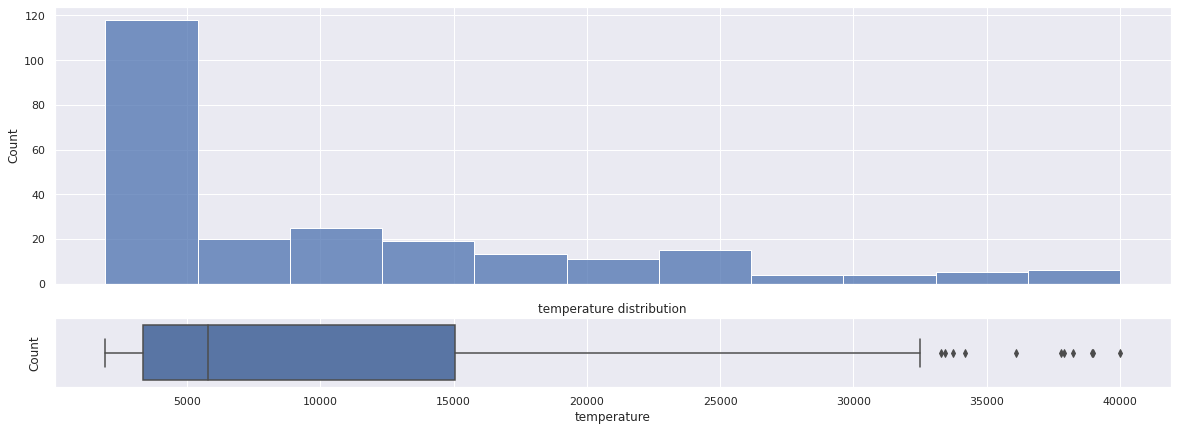

In [9]:
num_stat('temperature')

Половина звезд имеют температуру 5.000 кельвинов, максимальная температура состовляет до 40.000 кельвинов. Причем с увеличением температуры звезды уменьшается количество звезд. Большинство звезд имеет температуру 1939 кельвинов до 32.000. Судя по диаграмме размаха имеем значения детектированные как вбросы по температуре более 32.000 кельвинов. Т.к. данных не много не будем применять фильтрацию по статистической значимости.

#### luminosity

In [10]:
df['luminosity'].describe()

count       240.000000
mean     107188.361635
std      179432.244940
min           0.000080
25%           0.000865
50%           0.070500
75%      198050.000000
max      849420.000000
Name: luminosity, dtype: float64

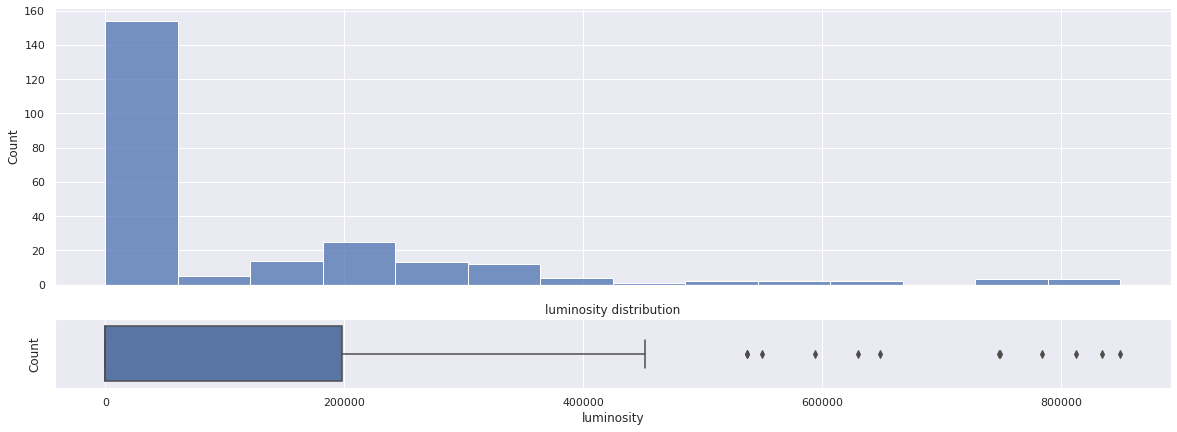

In [11]:
num_stat('luminosity')

Около 150 звезд имеет светимость до 0.07, остальная часть вплоть до 850.000, также наблюдаем небольшой пик количества звезд в районе светимости 200.000. Судя по диаграмме размаха основная часть звезд имеет светимость до 450.000.

На первый взгляд не видно линейной зависимости температуры поверхности звезды от ее светимости.

#### radius

In [12]:
df['radius'].describe()

count     240.000000
mean      237.157781
std       517.155763
min         0.008400
25%         0.102750
50%         0.762500
75%        42.750000
max      1948.500000
Name: radius, dtype: float64

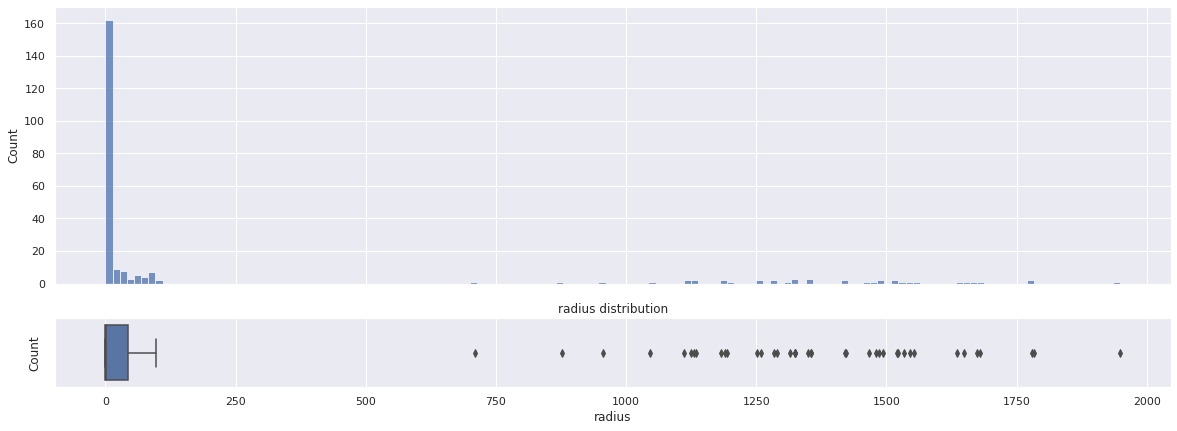

In [13]:
num_stat('radius')

Большинство звезд имеют радиус 0.76 от радиуса солнца. Звезды с большим радиусом детектируются как выбросы. Из-за малого количества данных не будем фильтровать данные. Линейной зависимости светимости от радиуса звезды не наблюдаем.

#### magnitude

In [14]:
df['magnitude'].describe()

count    240.000000
mean       4.382396
std       10.532512
min      -11.920000
25%       -6.232500
50%        8.313000
75%       13.697500
max       20.060000
Name: magnitude, dtype: float64

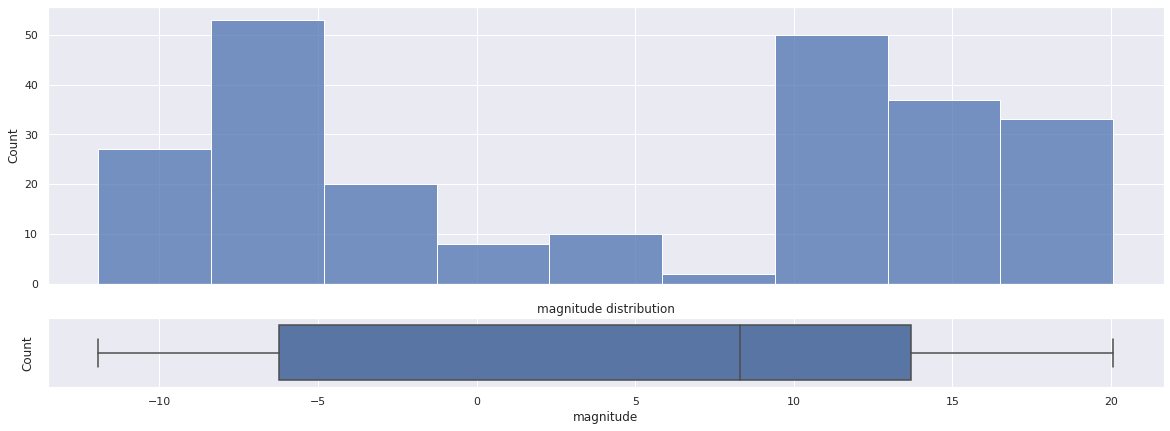

In [15]:
num_stat('magnitude')

`magnitude` - является мерой светимости небесного объекта в обратном логарифмическом масштабе астрономической величины.  Абсолютная величина объекта определяется как равная видимой величине , которую объект имел бы, если бы его наблюдали с расстояния ровно 10 парсеков (32,6 световых года ), без угасания (или затемнения) его света из-за поглощения межзвездными телами, материей и космической пылью. В наших данных светимсоть имеет диапазон от -12 до 20 едениц. Имеем два пика в количестве звезд с светимсотью от -5 до -10 и от 10 до 15 едениц

### Исследовательский анализ категориальных данных

#### star_type

| id | Описание |
| ------------ | ----- |
| 0 | Коричневый карлик |
| 1 | Красный карлик |
| 2 | Белый карлик |
| 3 | Звёзды главной последовательности |
| 4 | Сверхгигант |
| 5 | Гипергигант |

In [16]:
df['star_type'].unique()

array([0, 1, 2, 3, 4, 5])

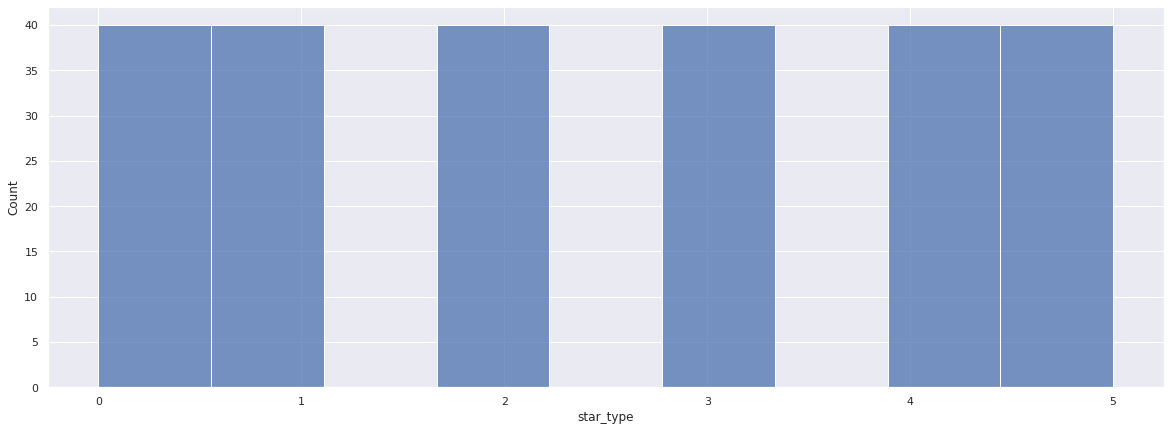

In [17]:
sns.histplot(x=df['star_type'], )
plt.show()

Имеем шесть категорий звезд, каждая категория представлена ровно 40 строками датасета.

#### star_color

Взглянем на уникальные значения столбца `star_color`:

In [18]:
df['star_color'].unique()

array(['Red', 'Blue White', 'White', 'Yellowish White', 'Blue white',
       'Pale yellow orange', 'Blue', 'Blue-white', 'Whitish',
       'yellow-white', 'Orange', 'White-Yellow', 'white', 'Blue ',
       'yellowish', 'Yellowish', 'Orange-Red', 'Blue white ',
       'Blue-White'], dtype=object)

Избавимся от неявных дубликатов:

In [19]:
df['star_color'] = df['star_color'].str.lower()
df['star_color'] = df['star_color'].map(str.strip)
df['star_color'] = df['star_color'].str.replace(' ', '_')
df['star_color'] = df['star_color'].str.replace('-', '_')
df['star_color'].unique()

array(['red', 'blue_white', 'white', 'yellowish_white',
       'pale_yellow_orange', 'blue', 'whitish', 'yellow_white', 'orange',
       'white_yellow', 'yellowish', 'orange_red'], dtype=object)

In [20]:
pd.DataFrame(df['star_color'].value_counts())

,star_color
red,112
blue,56
blue_white,41
white,10
yellow_white,8
yellowish_white,3
yellowish,3
orange,2
whitish,2
pale_yellow_orange,1


Почти половина звезд (112 шт.) имеет красный спектральный цвет, на втором месте по популярности находятся звезды с синим спектральным цветом (56 шт.), тройку лидеров по распространнености занимают звезды с бело-голубым спетром (41 шт.)

Так же мы видим что звезд начиная с белого спектра очень мало, поэтому выведим их в отдельную категорию `other`:

In [21]:
most_frequent = ['red', 'blue', 'blue_white']
df['star_color'] = df['star_color'].apply(lambda x: 'others' if x not in most_frequent else x)

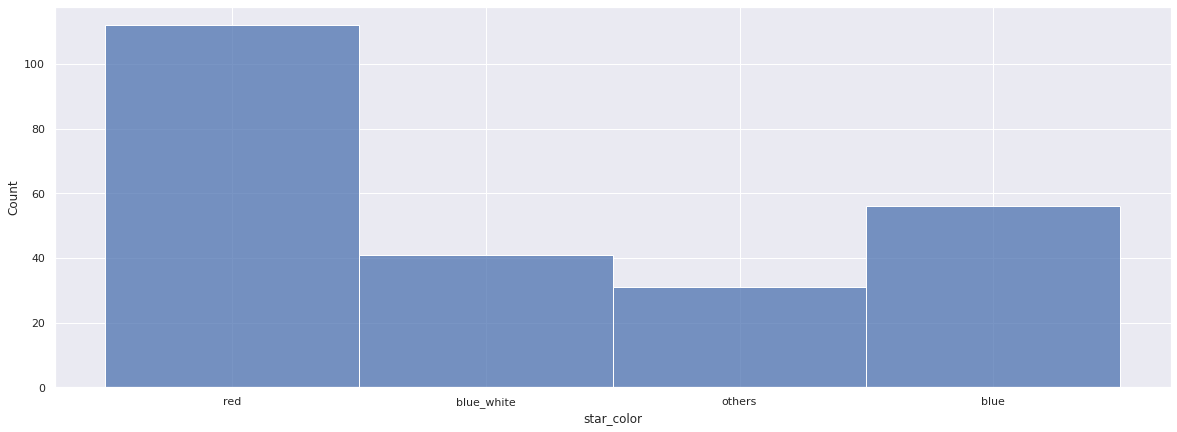

In [22]:
sns.histplot(x=df['star_color'], )
plt.show()

В данных по цвету звезды преобладает красный спектр.

### Подготовка данных к построению модели
По результату исследовательского анализа внесите корректировки, если они нужны. Сделайте вывод.

Если необходимо, категоризируйте исходные данные.

Считаю что категоризация данных не требуется.

Подготовьте обучающую и тестовую выборки.

Подготовим обучающую и тестовую выборку при помощи пакета sklearn.model_selection, размер тестовой выборки выберем 20%:

In [23]:
X_train, X_test, y_train, y_test = train_test_split(
    df.drop(columns=['temperature']), 
    df.temperature, 
    test_size=0.2, 
    random_state=RANDOM_SEED, 
    shuffle=True)

Произведем OHE кодирование данных в столбцах: `star_color` и `star_type`. Чтобы не попасть в `dummy` ловушку используем параметр: drop_first=True: 

In [24]:
ohe = OneHotEncoder()
ss = StandardScaler()

numeric = X_train.select_dtypes([np.float64]).columns
categorical = X_train.select_dtypes(include=['object', np.int64]).columns

col_transformer = ColumnTransformer(
                    transformers=[
                        ('ohe', OneHotEncoder(), categorical),
                        ('ss', StandardScaler(), numeric)
                    ], n_jobs=-1
                    )

In [25]:
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

Трансформируем train и test выборки в Tensor:

In [28]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.FloatTensor(y_train.values).reshape(y_train.shape[0], 1)
y_test = torch.FloatTensor(y_test.values).reshape(y_test.shape[0], 1)

## Построение простой модели нейронной сети — baseline

Создайте класс для задания архитектуры нейронной сети.

In [29]:
class Net1(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net1, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.relu1 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_1, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc3(x)
        
        return x

class Net2(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net2, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.relu1 = nn.Tanh()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        
        return x
    
class Net3(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(Net3, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.relu1 = nn.Tanh()
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.relu2 = nn.ReLU()
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3)
        self.relu3 = nn.ReLU()
        
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        
        x = self.fc3(x)
        x = self.relu3(x)
        
        x = self.fc4(x)
        
        return x

Самостоятельно выберите количество скрытых слоёв, количество нейронов на них, функции активации на скрытых и выходном слоях. Попробуйте и сравните несколько подобных комбинаций.

Проведите обучение нейронной сети:
* Создайте функцию для обучения нейронной сети.

In [30]:
rmse = MeanSquaredError(squared = False)

def train_net(X_train, y_train, num_epochs, model):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss = nn.MSELoss()
    num_epochs = num_epochs

    for epoch in range(num_epochs):
        optimizer.zero_grad()
        preds = model.forward(X_train)
        loss_value = loss(preds, y_train)
        loss_value.backward()
        optimizer.step()
        
    model.eval()
    metrics = rmse(model(X_test), y_test).item()
            
    return model, metrics

* Проведите обучение модели.

In [31]:
%time

n_neurons = list(range(300, 1500, 50))

samples = 15
n_in_neurons = X_train.size()[1]
n_out_neurons = 1

neuron_table = pd.DataFrame()

def learn(n_layers):

    for i in range(samples):
        if n_layers == 1 or n_layers == 2 or n_layers == 3:
            n_hidden_neurons_1 = n_neurons[np.random.randint(0, len(n_neurons))]
            n_hidden_neurons_2 = 0
            n_hidden_neurons_3 = 0
            net = Net1(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
            net, score = train_net(X_train, y_train, 1000, net)
            neuron_table.loc[i,['1 layer_ne']] = score
            neuron_table.loc[i,['1_layer_n_neurons']] = n_hidden_neurons_1
        if n_layers == 2 or n_layers == 3:
            n_hidden_neurons_2 = n_neurons[np.random.randint(0, len(n_neurons))]
            n_hidden_neurons_3 = 0
            net = Net2(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
            net, score = train_net(X_train, y_train, 1000, net)
            neuron_table.loc[i,['2 layer_ne']] = score
            neuron_table.loc[i,['2_layer_n_neurons']] = str(n_hidden_neurons_1) + ', ' + str(n_hidden_neurons_2)
        if n_layers == 3:
            n_hidden_neurons_3 = n_neurons[np.random.randint(0, len(n_neurons))]
            net = Net3(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)
            net, score = train_net(X_train, y_train, 1000, net)
            neuron_table.loc[i,['3 layer_ne']] = score
            neuron_table.loc[i,['3_layer_n_neurons']] = str(n_hidden_neurons_1) + ', ' + str(n_hidden_neurons_2) + ', ' + str(n_hidden_neurons_2)
        
layers = [1, 2, 3]

for layer in layers:
    learn(layer)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 6.91 µs


In [32]:
neuron_table

,1 layer_ne,1_layer_n_neurons,2 layer_ne,2_layer_n_neurons,3 layer_ne,3_layer_n_neurons
0,9588.622070,950.0,3705.745605,"950, 650",6654.728027,"950, 650, 650"
1,9736.766602,900.0,3479.738037,"900, 400",6915.054688,"900, 400, 400"
2,9733.751953,900.0,3838.757568,"900, 950",7379.245117,"900, 950, 950"
3,11360.685547,450.0,3391.156250,"450, 550",6848.662598,"450, 550, 550"
4,10755.059570,600.0,3681.328613,"600, 1000",7098.518066,"600, 1000, 1000"
5,8755.361328,1250.0,3940.589355,"1250, 950",7182.318359,"1250, 950, 950"
6,10979.359375,550.0,3701.692627,"550, 1100",7009.238281,"550, 1100, 1100"
7,10968.035156,550.0,3810.436279,"550, 1350",6489.141602,"550, 1350, 1350"
8,9297.859375,1050.0,3870.036621,"1050, 900",6484.054688,"1050, 900, 900"
9,8277.440430,1450.0,4138.370117,"1450, 1400",6598.831543,"1450, 1400, 1400"


По данным таблицы сверху, наилучшую метрику RMSE показывают модели с двумя скрытыми слоями. Для дальнейшей оптимизации будем использовать модель с двумя скрытыми слоями, по 1150 и 450 нейронов соответсвенно и nn.Tanh(), nn.ReLU(), nn.ReLU() функциями активации.

* Постройте график «Факт — Прогноз», где по горизонтальной оси будут отложены условные номера звёзд, а по вертикальной — температура в Кельвинах.

In [33]:
net = Net2(n_in_neurons, 1150, 450, 0, n_out_neurons)
net, metrics = train_net(X_train, y_train, 1000, net)

stat_table = pd.DataFrame(y_test.numpy(), columns=['real_temperature'])
predicted_temp = pd.DataFrame(net(X_test).detach().numpy(), columns=['predict_temperature'])

stat_table['predicted_temp'] = predicted_temp
stat_table = stat_table.sort_values(by='real_temperature').reset_index(drop=True)
stat_table.head()

,real_temperature,predicted_temp
0,2700.0,3140.510254
1,2778.0,2809.325195
2,2799.0,2764.718506
3,2983.0,3135.176758
4,2989.0,3082.863525


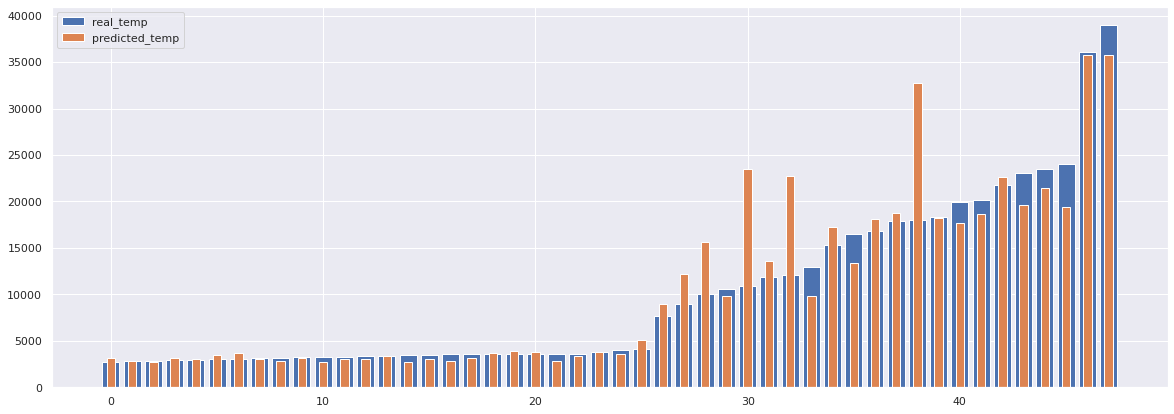

In [34]:
fig, ax = plt.subplots(figsize=[20, 7])

plt.bar(x=stat_table.index, height=stat_table['real_temperature'], label='real_temp')
plt.bar(x=stat_table.index, height=stat_table['predicted_temp'], label='predicted_temp', width= 0.4)
ax.legend()
plt.show()

Модель лучше предсказывает температуру звезд в диапазоне 2500 - 5000 К

## Улучшение нейронной сети

Создайте решение с перебором параметров нейросети. Список параметров для перебора должен включать как минимум «dropout» и «размер батча». Архитектуру нейронной сети: количество слоёв, нейронов, вид функции активации — оставьте как в Baseline, чтобы сравнить результат.



In [35]:
%time

# Задаем гиперпараметры для перебора
from math import ceil

batch_values = [16, 32, 64]
dropout = [0, 0.1, 0.2, 0.3]
num_epochs = 1000

loss = nn.MSELoss()
dropout_stat =pd.DataFrame()

# Создаем модель нейронной сети
class Net2Dropout(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2,
                 n_hidden_neurons_3, n_out_neurons, dropout):
        super(Net2Dropout, self).__init__()
        
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
        self.relu1 = nn.Tanh()
        self.dropout1 = nn.Dropout(p=dropout)
        
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout)
        
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        
        x = self.fc3(x)
        
        return x       

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


In [36]:
    for dropout_p in dropout:
        model = Net2Dropout(n_in_neurons, 1150, 450, 0, n_out_neurons, dropout_p)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            preds = model.forward(X_train)
            loss_value = loss(preds, y_train)
            loss_value.backward()
            optimizer.step()
        
        model.eval()
        metrics = rmse(model(X_test), y_test).item()
        
        index = dropout.index(dropout_p)
    
        dropout_stat.loc[index, ['dropout']] = dropout_p
        dropout_stat.loc[index, ['score']] = metrics

In [37]:
dropout_stat

,dropout,score
0,0.0,3573.974365
1,0.1,3480.413330
2,0.2,3478.280762
3,0.3,3460.459961


Как мы можем видеть из данных таблицы сверху, методика dropout не дает повышение метрики качества.

In [38]:
%time

batch_values = range(60, X_train.shape[0], 25)

batch_stat = pd.DataFrame()

for batch_size in batch_values:
    model = Net2(n_in_neurons, 1150, 450, 0, n_out_neurons)
    num_batches = ceil(len(X_train) / batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    for epoch in range(num_epochs):
        order = np.random.permutation(len(X_train))
        for batch_idx in range(num_batches):
            
            start_index = batch_idx * batch_size
            
            optimizer.zero_grad()
            
            batch_indexes = order[start_index:start_index + batch_size]
            
            x_batch = X_train[batch_indexes]
            y_batch = y_train[batch_indexes]
            
            preds = model(x_batch)
            
            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
    model.eval()
    with torch.inference_mode():
        score = rmse(model(X_test), y_test).item()
    index = batch_values.index(batch_size)
    
    batch_stat.loc[index, ['batch_size']] = batch_size
    batch_stat.loc[index, ['score']] = score

CPU times: user 24 µs, sys: 1e+03 ns, total: 25 µs
Wall time: 29.3 µs


In [39]:
batch_stat

,batch_size,score
0,60.0,4226.823242
1,85.0,4246.521484
2,110.0,3962.324463
3,135.0,3917.431885
4,160.0,3729.189697
5,185.0,3650.840332


Обучение батчами, также как и методика dropout не повышает метрику качества.

In [40]:
%time

score_list = []

model = Net2(n_in_neurons, 1150, 450, 0, n_out_neurons)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch_qnt in range(1, 5001):
    optimizer.zero_grad()
    preds = model.forward(X_train)
    loss_value = loss(preds, y_train)
    loss_value.backward()
    optimizer.step()
    if epoch_qnt % 10 == 0:
        score = rmse(model(X_test), y_test).item()
        score_list.append(score)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.11 µs


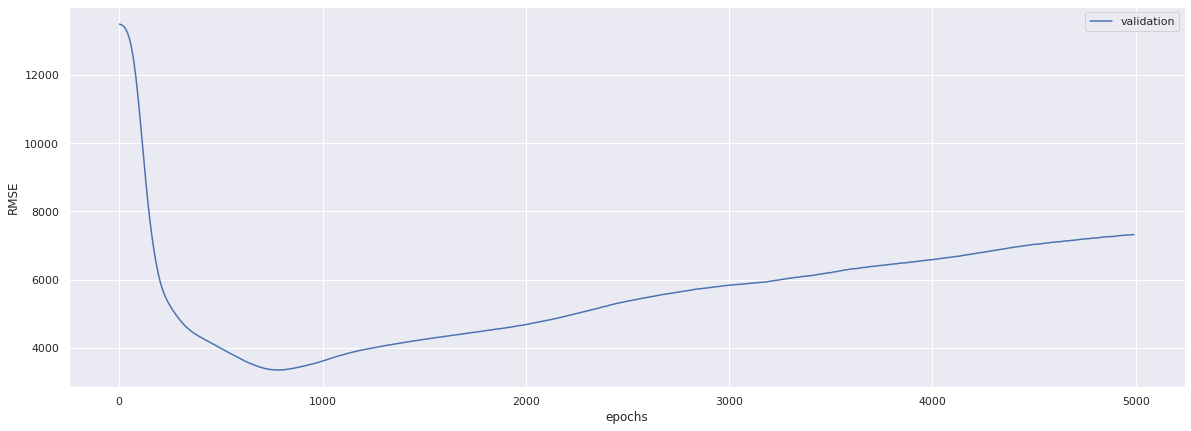

In [41]:
plt.figure(figsize=[20,7])
sns.lineplot(x=range(1, 5001, 10), y=score_list, label='validation')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.show()     

Судя по диаграмме сверху, оптимальное количество эпох обучения 1000, при увеличении количества эпох обучения - начинается падение метрики RMSE что свидетельствует о переобучении модели.

## Выводы

Кратко опишите результаты каждого типа модели.

Напишите выводы сравнения двух моделей.

В этом проекте мы создали модель нейросети для предсказания температуры на поверхности звезды.

Для начала мы загрузили данные и произвели EDA. Определили что данные имеют множество выбросов, но из-за малого количества данных мы не стали применять межквартильную фильтрацию. Вообще основная проблема этого проекта это количество данных, для обучения нейросетей требуется много данных, но получить данные из комоса весьма проблематично. Можно конечно было попробовать сгенерировать данные - но не в рамках этого проекта.

Методики dropout и batch не дали улучшения качества модели. В качестве архитектуры нейросети мы выбрали полносязную сеть с двумя скрытыми слоями, по 1150 и 450 нейронов соответсвенно и nn.Tanh(), nn.ReLU(), nn.ReLU() функциями активации. По итогу мы получили модель с метрикой RMSE в районе 3000, которая относительно хорошо предсказывает температуру в диапазоне 2500 - 5000К.